## 1. Finding cliques

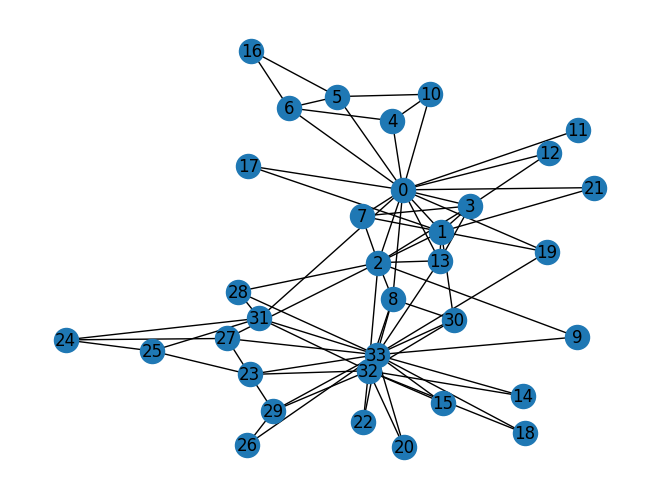

In [52]:
!pip install python-louvain
!pip install community

import networkx as nx

g = nx.karate_club_graph()
nx.draw(g,with_labels=True)

### Find all cliques of 4 or more

In [53]:
cliques = nx.find_cliques(g)
cliques4 = [clq for clq in cliques if len(clq) >= 4]

### Create a subgraph

In [54]:
nodes = set(n for clq in cliques4 for n in clq)
h = g.subgraph(nodes)

### Drop nodes of subgraph which have degree less than 4:

In [55]:
deg = nx.degree(h)
nodes = [n for n in nodes if deg[n] >= 4]

In [56]:
k = h.subgraph(nodes)


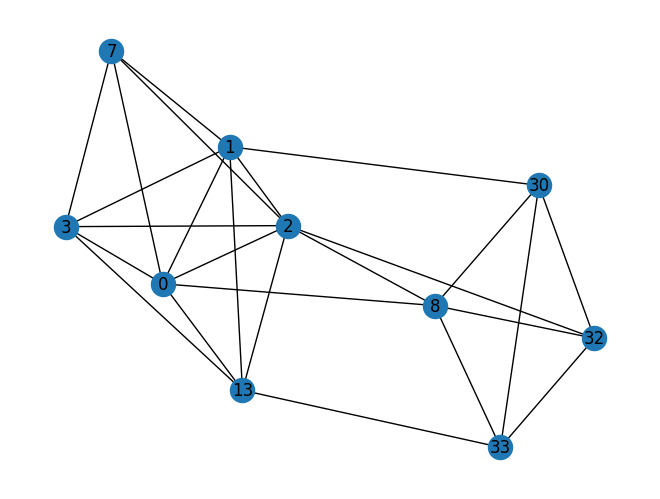

In [57]:
nx.draw(k,with_labels=True)

## 2. Graph partition

### A partition of a graph is a separation of its nodes into disjoint groups. Consider the following graph:


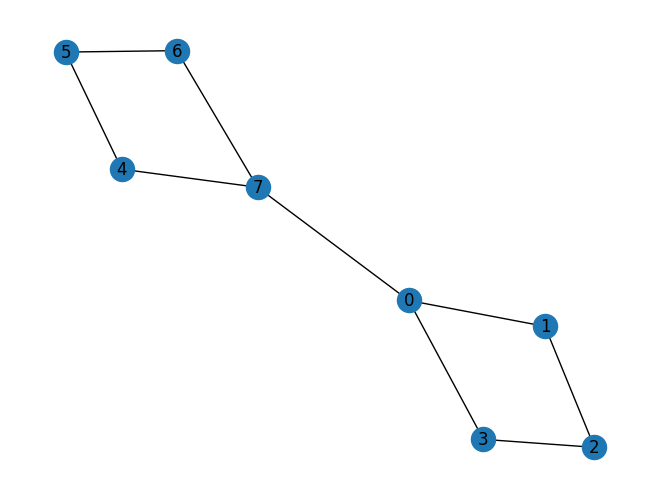

In [58]:
G = nx.Graph()
nx.add_cycle(G, [0, 1, 2, 3])
nx.add_cycle(G, [4, 5, 6, 7])
G.add_edge(0, 7)

nx.draw(G, with_labels=True)

In [59]:
partition = [
    {1, 2, 3},
    {4, 5, 6},
    {0, 7},
]

In [60]:
nx.community.is_partition(G, partition)


True

In [61]:
partition_map = {}
for idx, cluster_nodes in enumerate(partition):
    for node in cluster_nodes:
        partition_map[node] = idx

partition_map

{1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 0: 2, 7: 2}

In [62]:
partition_map[0] == partition_map[7]


True

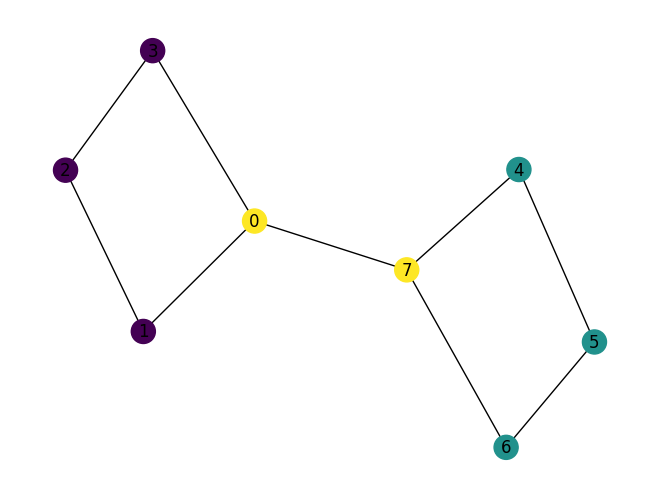

In [63]:
node_colors = [partition_map[n] for n in G.nodes]
        
nx.draw(G, node_color=node_colors, with_labels=True)

## 3. Modularity

### In the Community library, the module modularity is a greedy modularity. Let's compare the manual Modularity with the library

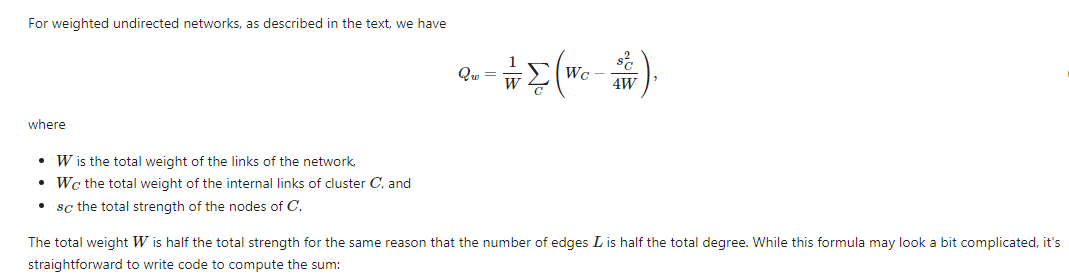

In [84]:
def modularity(G, partition):
    W = sum(G.edges[v, w].get('weight', 1) for v, w in G.edges)
    summation = 0
    for cluster_nodes in partition:
        s_c = sum(G.degree(n, weight='weight') for n in cluster_nodes)
        # Use subgraph to count only internal links
        C = G.subgraph(cluster_nodes)
        W_c = sum(C.edges[v, w].get('weight', 1) for v, w in C.edges)
        summation += W_c - s_c ** 2 / (4 * W)
    
    return summation / W

In [85]:
partition = [
    {0,1, 2, 3},
    {4, 5, 6,7},
]

modularity(G, partition)

0.3888888888888889

### Compare the modularity module with community library

In [86]:
import community as comm
bp = comm.best_partition(G)
comm.modularity(bp,G)

0.38888888888888884

### Let's compare this to a partition we would suspect to have higher modularity:


In [67]:
partition_2 = [
    {0, 1, 2, 3},
    {4, 5, 6, 7},
]
modularity(G, partition_2)

0.3888888888888889

### NetworkX function comparision


In [68]:
nx.community.quality.modularity(G, partition_2)

0.38888888888888884

## 4. Modularity in real graph

## Load the Karate Graph from NetworkX

In [69]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math
import plotly.express as px
import pandas as pd
import numpy as np

In [70]:
def get_graph_info(graph):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    print("Available nodes:", list(graph.nodes))
    print("Available edges:", list(graph.edges))
    if type(graph) == nx.classes.digraph.DiGraph:
        print("Connected components:", 
              list(nx.weakly_connected_components(directed_graph)))
    else:
        print("Connected components:", list(nx.connected_components(graph)))
    print("Node degree:", dict(graph.degree()))

In [71]:
# built-in graph from networkx
karate_graph = nx.karate_club_graph()
get_graph_info(karate_graph)

Number of nodes: 34
Number of edges: 78
Available nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Available edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)]
Connected components: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,

In [72]:
# club color reference
nation_color_dict = {
    'Mr. Hi': '#aff8df',
    'Officer': '#ffcbc1'
}

# function to assign color for node visualization
def create_node_colors_from_graph(graph, club_color_dict):
    node_colors = []
    for node, club in list(graph.nodes(data="club")):
        if club in club_color_dict:
            node_colors.append(club_color_dict[club])
    return node_colors

# get node colors for plotting
node_colors = create_node_colors_from_graph(karate_graph, nation_color_dict)


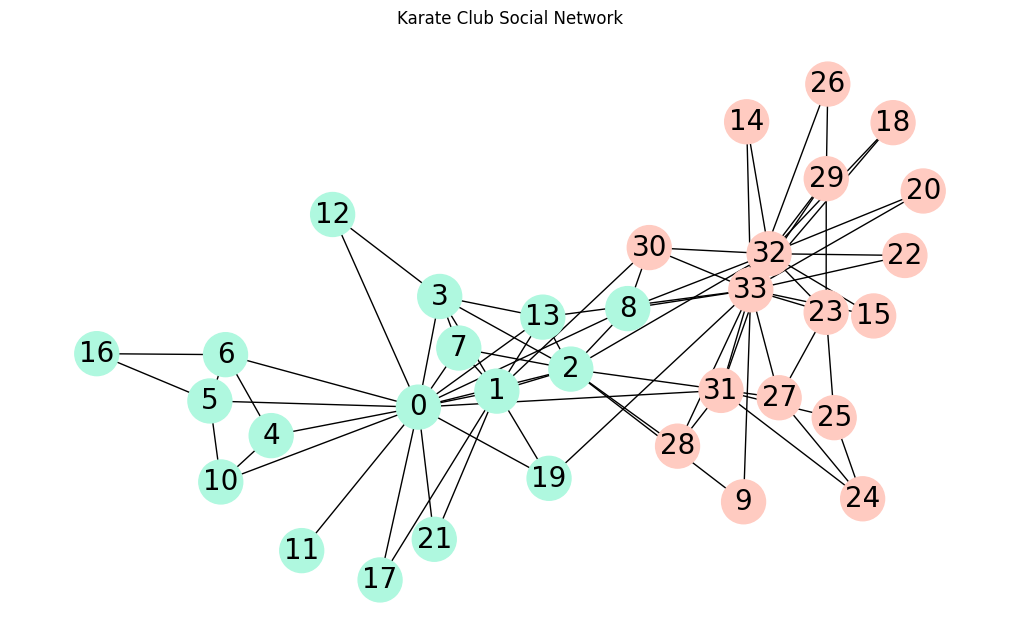

In [73]:
# create visualization
pos = nx.spring_layout(karate_graph, 
                       k=0.3, iterations=50,
                       seed=2)

plt.figure(1,figsize=(10,6)) 
nx.draw(karate_graph,
        pos = pos,
        node_color=node_colors,
        node_size=1000,
        with_labels=True,
        font_size = 20,
        font_color='black')
plt.title("Karate Club Social Network")
plt.show()

### Modularity:

In [74]:
# function to return a node's neighbor nodes as a list
def get_neighbors(graph, node):
    return [n for n in graph.neighbors(node)]

In [75]:
# function to return the subgraph containing 2 nodes' common neighbors
def get_common_neighbor_subgraph(graph, source, target):
    nodes = [source, target] + list(nx.common_neighbors(karate_graph, source, target))
    return graph.subgraph(nodes)

## 5. Louvain method





In [76]:
import community.community_louvain as community_louvain
import networkx.algorithms.community as nx_comm


In [77]:
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#EF9A9A", "#BA68C8", "#64B5F6", "#81C784",
              "#FFF176", "#BDBDBD"][:number_of_colors]
    node_colors = []
    
    # iterate each node in the graph and find which community it belongs to
    # if the current node is found at a specific community, add color to the 
    # node_colors list
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

In [78]:
# convert the python-louvain package output to 
# NetworkX package community function output format
def get_louvain_communities(graph, random_state=1):
    louvain_partition_dict = community_louvain.best_partition(graph, random_state=random_state)
    unique_partition_labels = list(set(louvain_partition_dict.values()))
    communities = [[] for i in range(len(unique_partition_labels))]
    for node in louvain_partition_dict.keys():
        communities[louvain_partition_dict[node]].append(node)
    return communities

In [79]:
# get communities using louvain algorithm
louvain_communities = get_louvain_communities(karate_graph, random_state=1)
louvain_communities

[[0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21],
 [4, 5, 6, 10, 16],
 [24, 25, 28, 31],
 [8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33]]

In [80]:
def visualize_communities(graph, communities):
    # create visualization
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx_comm.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, 
                           k=0.3, iterations=50,
                           seed=2)

    plt.figure(1,figsize=(10,6)) 
    nx.draw(graph,
            pos = pos,
            node_size=1000,
            node_color=node_colors,
            with_labels=True,
            font_size = 20,
            font_color='black')
    plt.title(title)
    plt.show() 

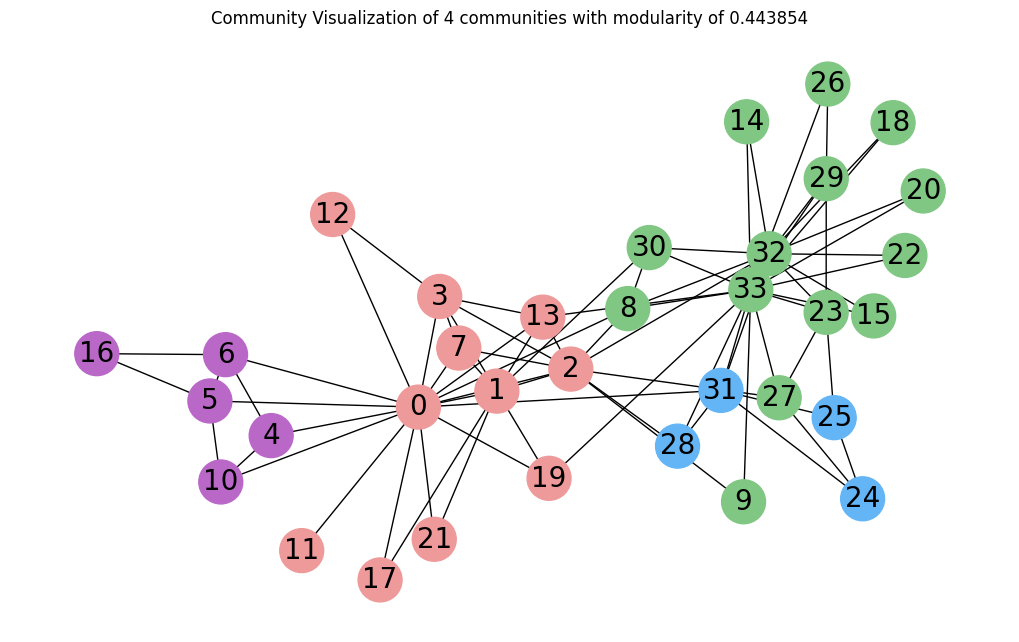

In [81]:
visualize_communities(karate_graph, louvain_communities)


### Let's visualize the subgraphs

In [82]:
def visualize_subgraph(graph, subgraph_nodes, node_color):
    # get subgraph
    subgraph = nx.subgraph(graph, subgraph_nodes)

    # create visualization
    node_colors = [node_color] * len(subgraph_nodes)
    title = f"Community Partition Subgraph"
    pos = nx.spring_layout(subgraph, 
                           k=0.3, iterations=50,
                           seed=2)

    plt.figure(1,figsize=(8,6)) 
    nx.draw(subgraph,
            pos = pos,
            node_size=1000,
            node_color=node_colors,
            with_labels=True,
            font_size = 20,
            font_color='black')
    plt.title(title)
    plt.show() 

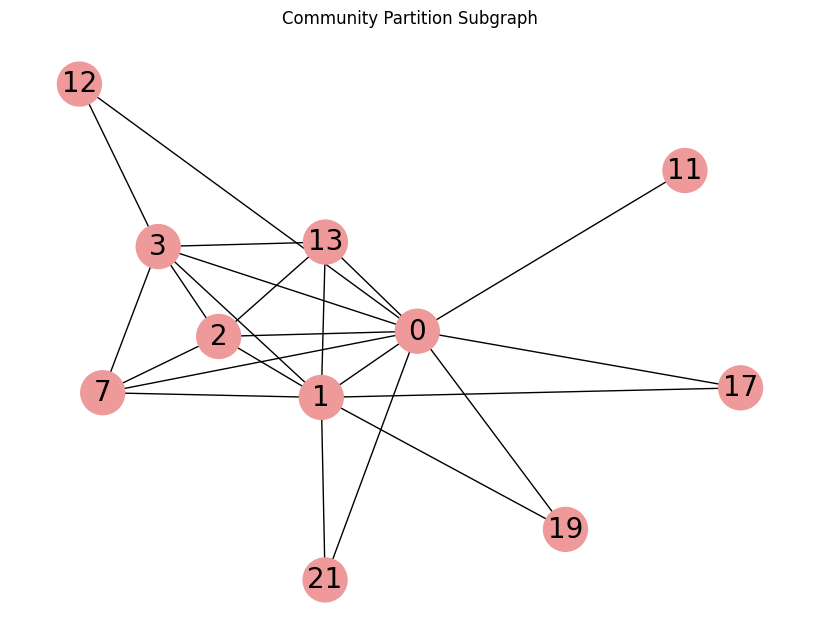

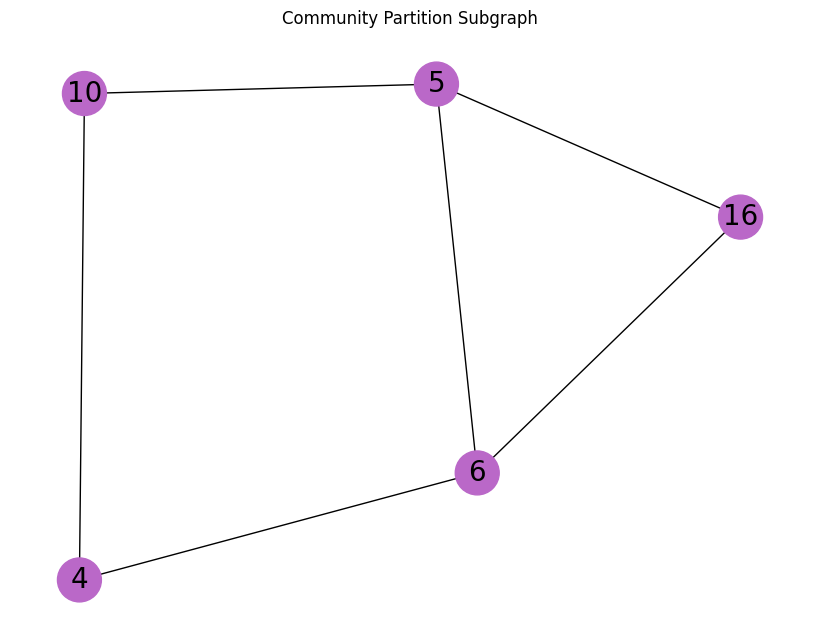

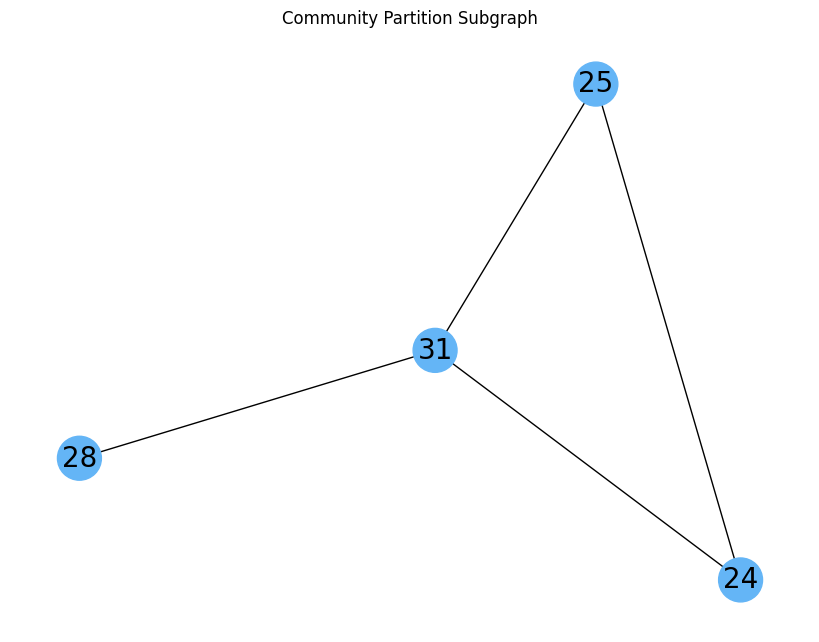

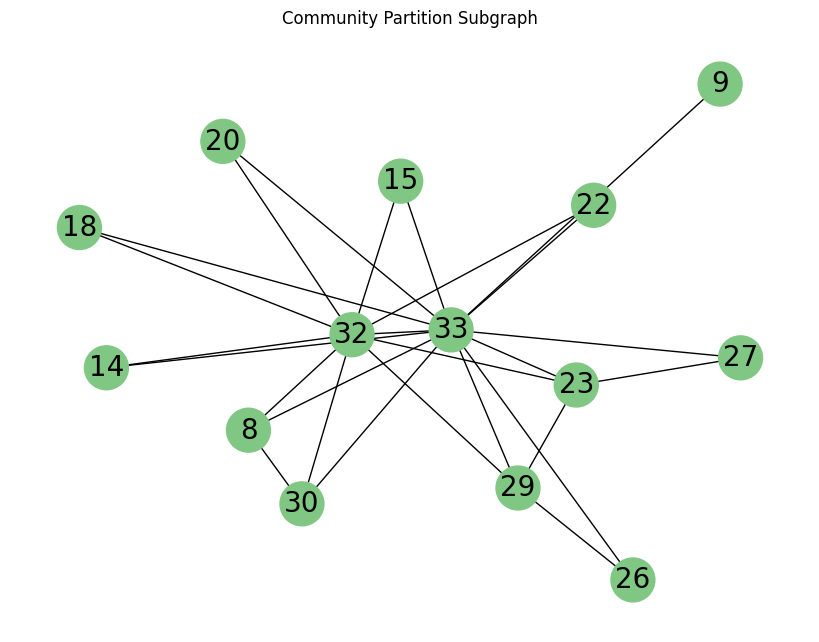

In [83]:
colors = ["#EF9A9A", "#BA68C8", "#64B5F6", "#81C784", "#FFF176", "#BDBDBD"]
for i in range(len(louvain_communities)):
    visualize_subgraph(karate_graph, louvain_communities[i], colors[i])